# Exponential smoothing

Some of the most successful forecasting methods are based on the concept of exponential smoothing. There are a variety of methods that fall into
the exponential smoothing family, each having the property that forecasts
are weighted combinations of past observations, with recent observations
given relatively more weight than older observations. The name _“exponential smoothing”_ reflects the fact that the weigth decrease exponentially as the observations get older.

### Index
* [Simple exponential smoothing](#Simple)
* [Holt's linear method](#Holt)
* [Holt-Winters](#HoltWinters)

#### Packages

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import seaborn as sns

import statsmodels.tsa.api as sm

import warnings
warnings.filterwarnings("ignore")

In [2]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [3]:
sns.set_style("whitegrid")

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

small_size = 12
medium_size = 14
large_size = 16

matplotlib.rc("font", size=small_size)  
matplotlib.rc("axes", titlesize=small_size) 
matplotlib.rc("axes", labelsize=medium_size) 
matplotlib.rc("xtick", labelsize=small_size) 
matplotlib.rc("ytick", labelsize=small_size)  
matplotlib.rc("legend", fontsize=small_size) 
matplotlib.rc("axes", titlesize=large_size) 

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape
from sklearn.metrics import mean_squared_error

#### Load data

In [5]:
train = pd.read_parquet("../data/03_train-test/train_data.parquet")
test = pd.read_parquet("../data/03_train-test/test_data.parquet")

In [6]:
data = pd.read_parquet("../data/02_intermediate/summed_data.parquet")
data

,tsd,is_holiday,month,year
settlement_date,,,,
2009-01-01,1849363.0,1,1,2009
2009-01-02,1974406.0,0,1,2009
2009-01-03,1952054.0,0,1,2009
2009-01-04,1968670.0,0,1,2009
2009-01-05,2271471.0,0,1,2009
...,...,...,...,...
2023-04-21,1330791.0,0,4,2023
2023-04-22,1229948.0,0,4,2023
2023-04-23,1241704.0,0,4,2023


In [7]:
threshold_date = "01-01-2021"

train_plot = data.loc[data.index < threshold_date, "tsd"].to_frame()
test_plot  = data.loc[data.index >= threshold_date, "tsd"].to_frame()

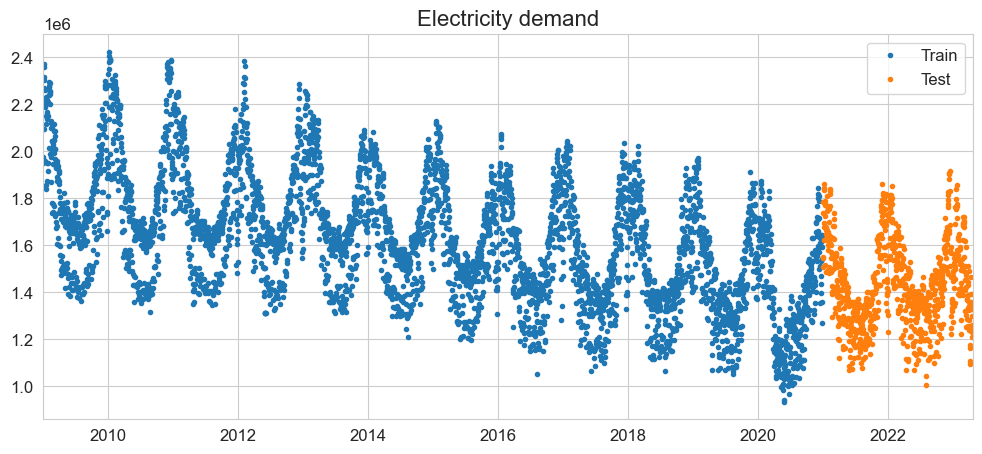

In [8]:
train_plot['tsd'].plot(style=".",figsize=(12, 5),label='Train')
test_plot['tsd'].plot(style=".",figsize=(12, 5),label='Test')
plt.title('Electricity demand')
plt.xlabel('')
plt.legend()
plt.show()

<a id='Simple'></a>
## Simple exponential smoothing

The simple exponential smoothing model is the simplest in this family. This technique can only be applied to data that has no trend o seasonal component.

The method of simple exponential smoothing, due to Brown's work in the 1950s, takes the forecast for the previous period and adjusts it using the forecast error. The forecast for the next period is

\begin{equation} \label{eq:simple_exp} \tag{1}
   \hat{X}_{t+1} = \hat{X}_t + \alpha (X_t - \hat{X}_t), 
\end{equation}

It can be seen that the new forecast is simply the old forecast plus an adjustement for the error that occurred in the last forecast. When $\alpha$ has a value close to $1$, the next forecast will include a substantial adjustment for the error in the previous forecast. Conversely, when $\alpha$ is close to $0$, the new forecast will include very litle adjustment.

Another way of writing \eqref{eq:simple_exp} is

\begin{equation} \label{eq:simple_exp2}
    \hat{X}_{t+1} = \alpha X_t + (1-\alpha)\hat{X}_t. 
\end{equation}

The forecast $\hat{X}_{t+1}$ is based on weighting the most recent observation $X_t$ with a weight value $\alpha$, and weighting the most recent forecast $\hat{X}_t$ with a weight of $1-\alpha$. Thus, is can be interpreted as a weighted average of the most recent and the most recent observation.

**Python implementation**

The limitation of this method is that it cannot model data that exhibits trend or seasonality. In order to apply it, we will remove these components.

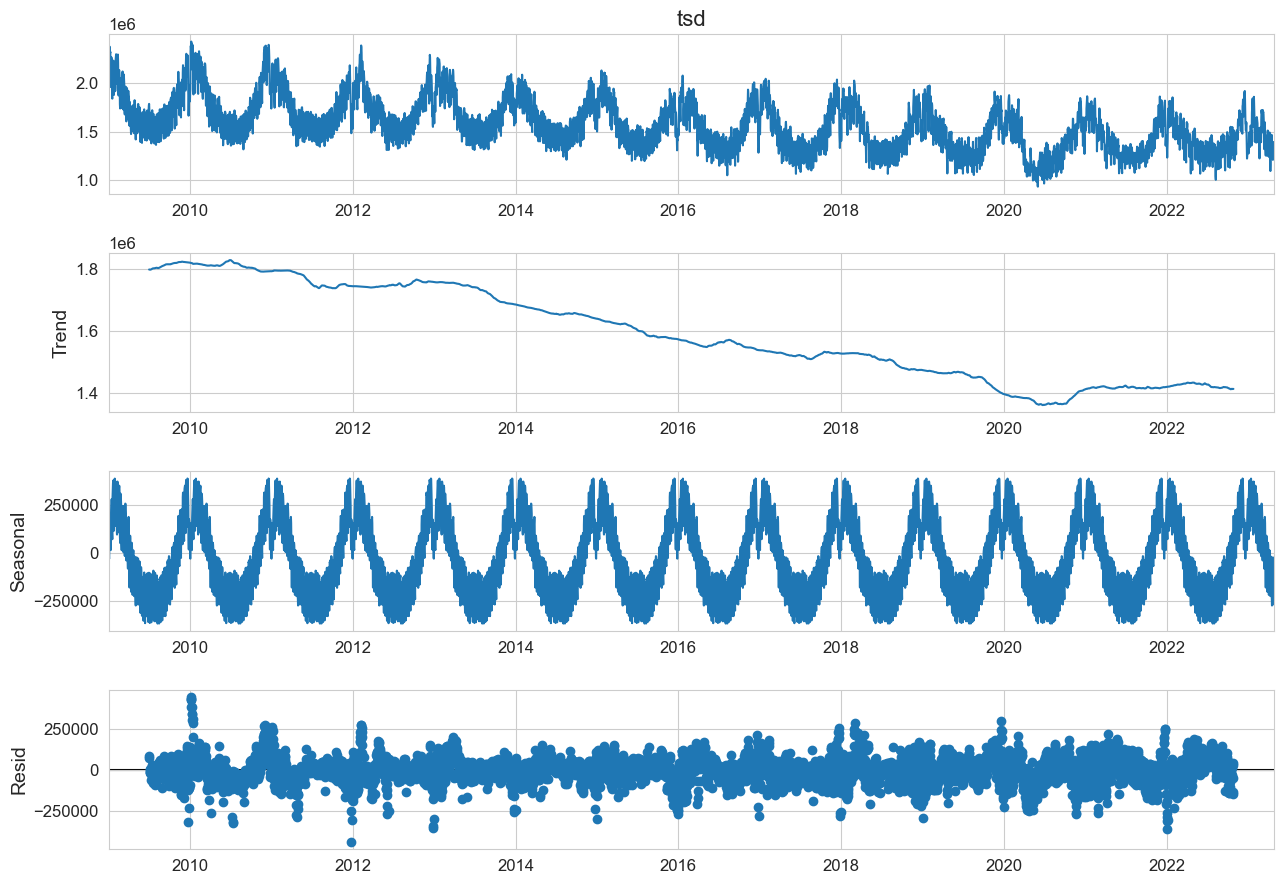

In [9]:
decompose = sm.seasonal_decompose(data["tsd"], period=364)

fig = decompose.plot()
fig.set_size_inches((13, 9))
fig.tight_layout()

In [10]:
detrend = sm.seasonal_decompose(decompose.resid.dropna(), period=7).resid.dropna()

In [11]:
threshold_date = "01-01-2021"
train2 = detrend.loc[detrend.index < threshold_date].to_frame()
test2 = detrend.loc[detrend.index >= threshold_date].to_frame()

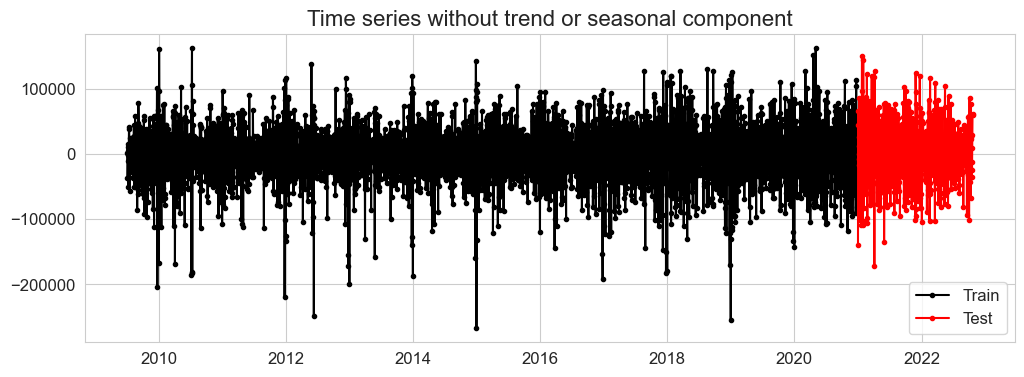

In [12]:
plt.figure(figsize=(12, 4))
plt.title('Time series without trend or seasonal component')
plt.plot(train2, marker=".", color="black", label='Train')
plt.plot(test2, marker=".", color="red", label='Test')
plt.legend()
plt.show()

In [13]:
# First try for the Simple Exponential Smoothing
Simple = SimpleExpSmoothing(train2).fit(smoothing_level=0.5)
S_fcast = Simple.forecast(len(test2))

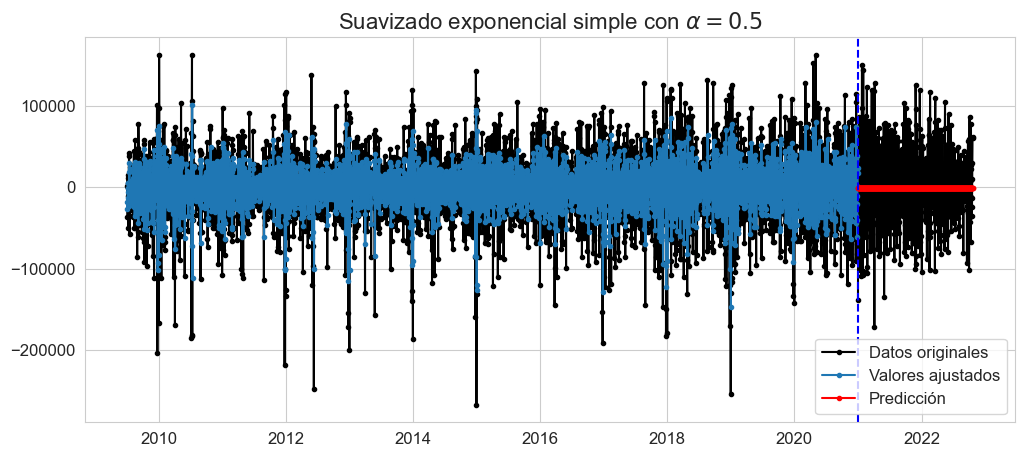

In [15]:
plt.figure(figsize=(12, 5))
plt.title(r'Suavizado exponencial simple con $\alpha=0.5$')
plt.plot(train2, marker=".", color="black", label='Datos originales')
plt.plot(test2, marker=".", color="black")
plt.plot(Simple.fittedvalues, marker='.', label='Valores ajustados')
plt.plot(S_fcast, marker=".", color="red", label='Predicción')
plt.axvline(datetime.date(2021,1,1), color="blue", ls="--")
plt.legend()

plt.savefig("../graphs/SimpleES1.png")

In [16]:
# More examples

t1 = time.perf_counter()
Simple1 = SimpleExpSmoothing(train2, initialization_method="heuristic").fit(smoothing_level=0.2, optimized=False)
S_fcast1 = Simple1.forecast(len(test2)).rename(r"$\alpha=0.2$")

t2 = time.perf_counter()
Simple2 = SimpleExpSmoothing(train2, initialization_method="heuristic").fit(smoothing_level=0.6, optimized=False)
S_fcast2 = Simple2.forecast(len(test2)).rename(r"$\alpha=0.6$")

t3 = time.perf_counter()
Simple3 = SimpleExpSmoothing(train2, initialization_method="estimated").fit()
S_fcast3 = Simple3.forecast(len(test2)).rename(r"$\alpha=%s$" % Simple3.model.params["smoothing_level"])
t4 = time.perf_counter()

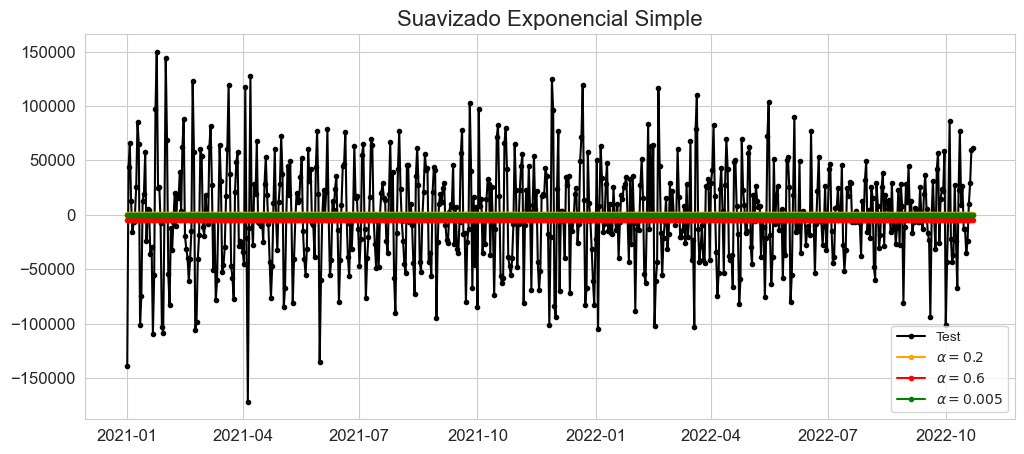

In [18]:
plt.figure(figsize=(12, 5))
plt.title('Suavizado Exponencial Simple')
# (data1,) = plt.plot(train2, marker=".", color="black", label='Original data')
(data1,) = plt.plot(test2, marker=".", color='black')
(line1,) = plt.plot(S_fcast1, marker=".", color="orange")
(line2,) = plt.plot(S_fcast2, marker=".", color="red")
(line3,) = plt.plot(S_fcast3, marker=".", color="green")

plt.legend([data1, line1, line2, line3], ['Test', S_fcast1.name, S_fcast2.name, S_fcast3.name], fontsize=10)
# plt.axvline(datetime.date(2021,1,1), color="blue", ls="--")
plt.savefig("../graphs/SimpleES2.jpg")

In [19]:
params = [
    "smoothing_level",
    "initial_level"
]
results1 = pd.DataFrame(
    index=[r"$\alpha$", r"$l_0$", "SSE", 'MAPE', 'MSE', 'Time'],
)


results1["Simple1"] = [Simple1.params[p] for p in params] + [Simple1.sse] + [mean_absolute_percentage_error(y_pred=S_fcast1, y_true=test2)] + [mean_squared_error(y_pred=S_fcast1, y_true=test2)] + [datetime.timedelta(seconds=t2-t1)]
results1["Simple2"] = [Simple2.params[p] for p in params] + [Simple2.sse] + [mean_absolute_percentage_error(y_pred=S_fcast2, y_true=test2)] + [mean_squared_error(y_pred=S_fcast2, y_true=test2)] + [datetime.timedelta(seconds=t3-t2)]
results1["Simple3"] = [Simple3.params[p] for p in params] + [Simple3.sse] + [mean_absolute_percentage_error(y_pred=S_fcast3, y_true=test2)] + [mean_squared_error(y_pred=S_fcast3, y_true=test2)] + [datetime.timedelta(seconds=t4-t3)]

results1

,Simple1,Simple2,Simple3
$\alpha$,0.2,0.6,0.005
$l_0$,-9935.289315,-9935.289315,-9935.289315
SSE,8869728883819.794922,10560635345516.949219,7557101157860.963867
MAPE,102.090779,153.664656,99.837198
MSE,2070655166.714875,2095784007.447468,2070649279.637655
Time,0:00:00.014078,0:00:00.010741,0:00:00.017595


In the third model, $\alpha$ is obtained maximizing the log-likelihood.

In [21]:
results1.to_csv('../data/results/SimpleES')

<a id='Holt'></a>
## Holt's linear method

Holt extended simple exponential smoothing to linear exponential smoothing to allow forecasting of data with **trends**. The forecast for
Holt’s linear exponential smoothing method is found using two smoothing
constants, $\alpha$ and $\beta^*$ (with values between $0$ and $1$), and three equations:


\begin{align*}
\text{Level:} \quad& l_t = \alpha X_t + (1-\alpha)(l_{t-1} + b_{t-1}),\\
\text{Growth:} \quad& b_t = \beta^*(l_t - l_{t-1}) + (1-\beta^*)b_{t-1},\\
\text{Forecast:} \quad& \hat{X}_{t+h \mid t} = l_t + b_th.
\end{align*}

$l_t$ denotes an estimate of the level of the series at time $t$ and $b_t$ denotes an estimate of the growth of the series at time $t$. 


The first step is removing the seasonal component.

In [19]:
deseason = decompose.trend.dropna()

In [20]:
threshold_date = "01-01-2021"
train3 = deseason.loc[deseason.index < threshold_date]
test3 = deseason.loc[deseason.index >= threshold_date]

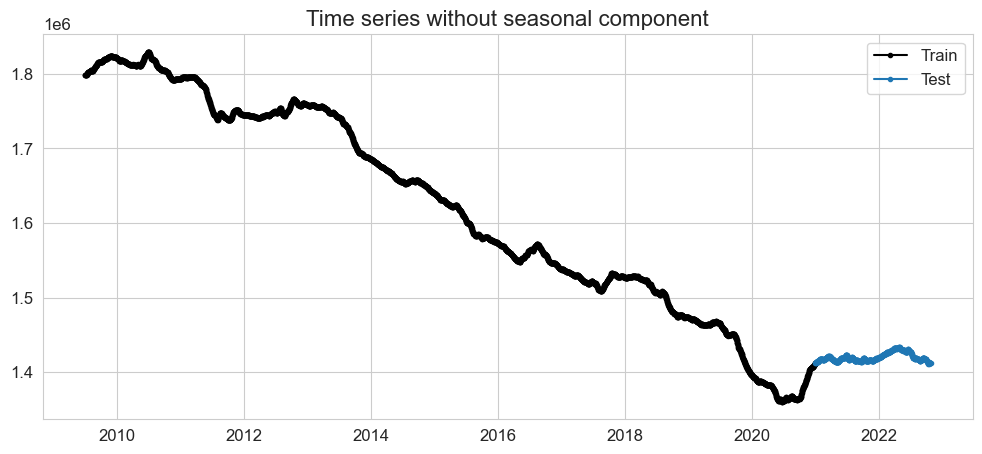

In [21]:
plt.figure(figsize=(12, 5))
plt.title('Time series without seasonal component')
plt.plot(train3, marker=".", color="black", label='Train')
plt.plot(test3, marker=".", label='Test')
plt.legend()
plt.show()

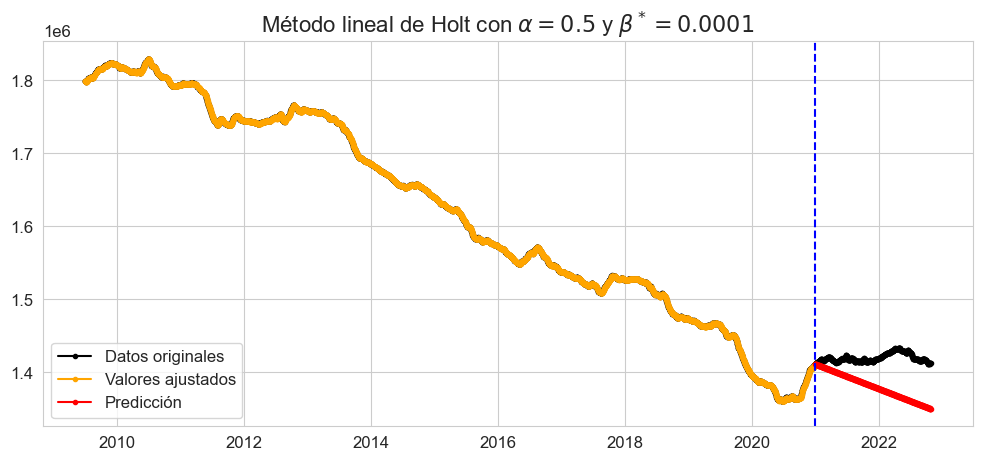

In [30]:
Holtm = Holt(train3).fit(smoothing_level=0.5, smoothing_trend=0.0001)
H_fcast = Holtm.forecast(len(test3)).rename("Holt's linear trend")

plt.figure(figsize=(12, 5))
plt.title(r"Método lineal de Holt con $\alpha=0.5$ y $\beta^*=0.0001$")
plt.plot(train3, marker=".", color="black", label = 'Datos originales')
plt.plot(test3, marker=".", color='black')
plt.plot(Holtm.fittedvalues, marker='.', color="orange", label='Valores ajustados')
(line1,) = plt.plot(H_fcast, marker=".", color="red", label='Predicción')
plt.axvline(datetime.date(2021,1,1), color="blue", ls="--")
plt.legend()

plt.savefig("../graphs/Holt1.jpg")

In [24]:
t1 = time.perf_counter()
Holt1 = Holt(train3, initialization_method="estimated").fit()
H_fcast1 = Holt1.forecast(len(test3)).rename("Aditivo")

t2 = time.perf_counter()
Holt2 = Holt(train3, exponential=True, initialization_method="estimated").fit()
H_fcast2 = Holt2.forecast(len(test3)).rename("Multiplicativo")

t3 = time.perf_counter()
Holt3 = Holt(train3, damped_trend=True, initialization_method="estimated").fit()
H_fcast3 = Holt3.forecast(len(test3)).rename("Aditivo amortiguado")

t4 = time.perf_counter()

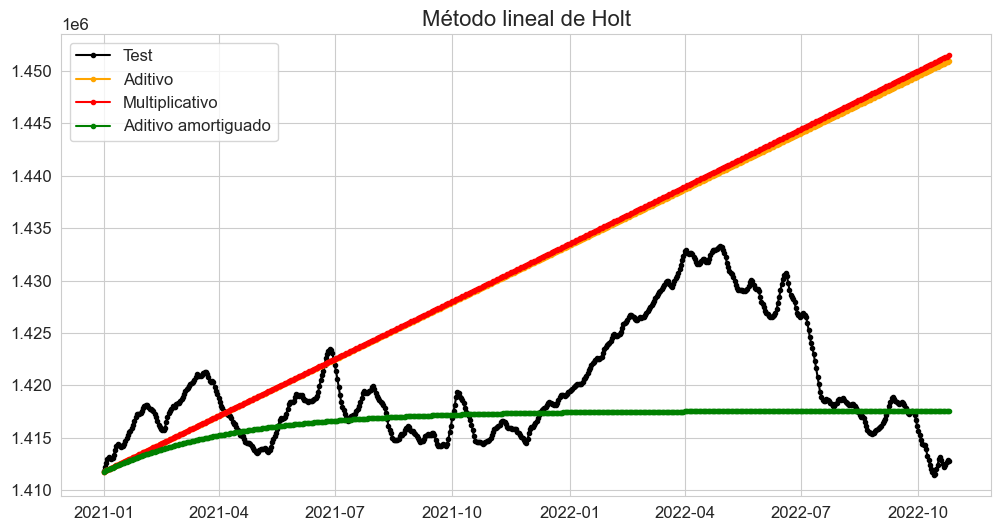

In [25]:
plt.figure(figsize=(12, 6))
plt.title("Método lineal de Holt")
# plt.axvline(datetime.date(2021,1,1), color="k", ls="--")
# (data1,) = plt.plot(train3, marker=".", color="black", label='Original data')
(data2,) = plt.plot(test3, marker=".", color='k')
(line1,) = plt.plot(H_fcast1, marker=".", color="orange")
(line2,) = plt.plot(H_fcast2, marker=".", color="red")
(line3,) = plt.plot(H_fcast3, marker=".", color="green")
plt.legend([data2, line1, line2, line3], ['Test', H_fcast1.name, H_fcast2.name, H_fcast3.name])


plt.savefig("../graphs/Holt2.jpg")

In [88]:
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "initial_level",
    "initial_trend",
]
results2 = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$l_0$", "$b_0$", "SSE", "MAPE", 'MSE', "Time"])
results2["Holt1"] = [Holt1.params[p] for p in params] + [Holt1.sse] + [mean_absolute_percentage_error(y_pred=H_fcast1, y_true=test3)] + [mean_squared_error(y_pred=H_fcast1, y_true=test3)] + [datetime.timedelta(seconds=t2-t1)]
results2["Holt2"] = [Holt2.params[p] for p in params] + [Holt2.sse] + [mean_absolute_percentage_error(y_pred=H_fcast2, y_true=test3)] + [mean_squared_error(y_pred=H_fcast2, y_true=test3)] + [datetime.timedelta(seconds=t3-t2)]
results2["Holt3"] = [Holt3.params[p] for p in params] + [Holt3.sse] + [mean_absolute_percentage_error(y_pred=H_fcast3, y_true=test3)] + [mean_squared_error(y_pred=H_fcast3, y_true=test3)] + [datetime.timedelta(seconds=t4-t3)]

results2

,Holt1,Holt2,Holt3
$\alpha$,0.995,0.995,0.995
$\beta$,0.995,0.995,0.995
$\phi$,NaN,NaN,0.99
$l_0$,1798510.538033,1798510.538033,1798510.538033
$b_0$,25.638428,1.000014,25.638428
SSE,74991648.577864,74983686.955882,74280287.161243
MAPE,0.857251,0.870046,0.316569
MSE,240375549.737305,247678145.448433,38977453.899351
Time,0:00:00.171103,0:00:00.187462,0:00:00.165735


In [89]:
results2.to_csv('../data/results/Holt.csv')

<a id='HoltWinters'></a>
## Holt-Winthers algorimth

Holt and Winters extended the Holt's linear method to incorpore the seasonal component. The Holt-Winters algorithm consists of three smoothing equations: one for the level $l_t$, other for the growth $b_t$ and the last one for the seasonal component $s_t$. Each equation corresponds to a smoothing parameter $\alpha$, $\beta^*$ and $\gamma$, respectively.


\begin{align*}
\text{Level:} \quad& l_t = \alpha(X_t - s_{t-s}) + (1-\alpha)(l_{t-1} + b_{t-1}),\\
\text{Growth:} \quad& b_t = \beta^*(l_t - l_{t-1}) + (1-\beta^*)b_{t-1},\\
\text{Seasonal:} \quad& s_t = \gamma (X_t  - l_{t-1} - b_{t-1}) + (1-\gamma)s_{t-s},\\
\text{Forecast:} \quad& \hat{X}_{t+h\mid t} = l_t + b_th + s_{t+h-s(k+1)},
\end{align*}

where $s$ is the length of the seasonality and $k = \lfloor (h-1)/m \rfloor$, which ensures that the estimates of the seasonal indices used for the prediction come from the last year of the sample

#### First model 

In [26]:
train4 = pd.read_parquet("../data/03_train-test/summed_data_train.parquet")
test4 = pd.read_parquet("../data/03_train-test/summed_data_test.parquet")

In [27]:
%%time
fit = ExponentialSmoothing(train4,
                           trend='add',
                           seasonal='add',
                           freq='D',
                           seasonal_periods=364,
                           initialization_method="estimated",
                          ).fit(smoothing_level=0.2, smoothing_trend=0.0001, smoothing_seasonal=0.1)


fcast = fit.forecast(845)

Wall time: 7.04 s


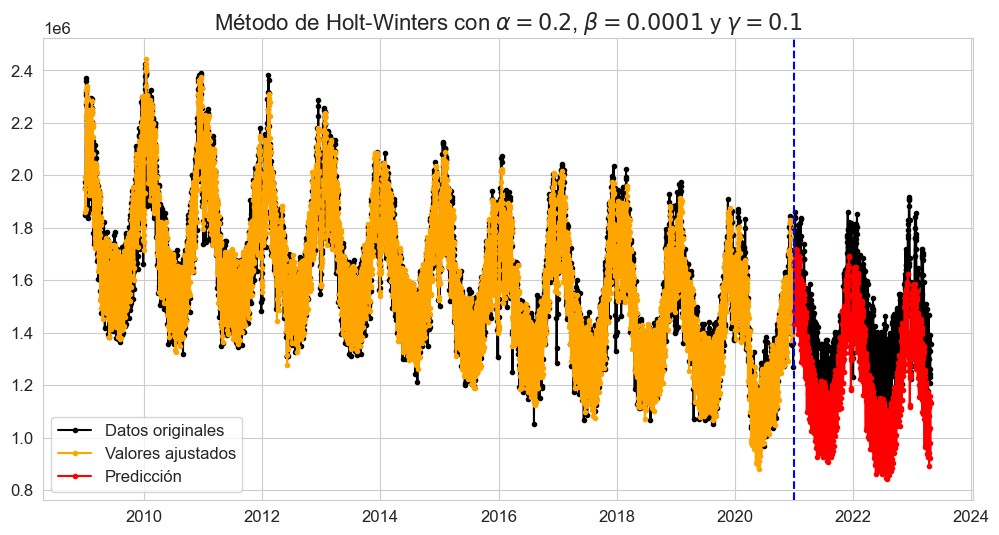

In [29]:
plt.figure(figsize=(12, 6))
plt.title(r'Método de Holt-Winters con $\alpha=0.2$, $\beta=0.0001$ y $\gamma=0.1$')
plt.plot(train4, marker=".", color="black", label='Datos originales')
plt.plot(test4, marker=".", color='black')
plt.plot(fit.fittedvalues, color="orange", marker='.', label='Valores ajustados')
plt.plot(fcast, color="red", marker='.', label='Predicción')
plt.axvline(datetime.date(2021,1,1), color="blue", ls="--")
plt.legend()
plt.savefig("../graphs/HoltWinters1.jpg")

In [32]:
t1 = time.perf_counter()
HW1 = ExponentialSmoothing(
    train4,
    seasonal_periods=365,
    trend="add",
    seasonal="add",
    freq='D',
    initialization_method="estimated").fit()
HW_fcast1 = HW1.forecast(len(test4))

t2 = time.perf_counter()
HW2 = ExponentialSmoothing(
    train4,
    seasonal_periods=365,
    trend="add",
    seasonal="mul",
    freq='D',
    initialization_method="estimated").fit()
HW_fcast2 = HW2.forecast(len(test4))

t3 = time.perf_counter()
HW3 = ExponentialSmoothing(
    train4,
    seasonal_periods=365,
    trend="add",
    seasonal="add",
    freq='D',
    damped_trend=True,
    initialization_method="estimated").fit()
HW_fcast3 = HW3.forecast(len(test4))

t4 = time.perf_counter()
HW4 = ExponentialSmoothing(
    train4,
    seasonal_periods=365,
    trend="add",
    seasonal="mul",
    freq='D',
    damped_trend=True,
    initialization_method="estimated").fit()
HW_fcast4 = HW4.forecast(len(test4))
t5 = time.perf_counter()

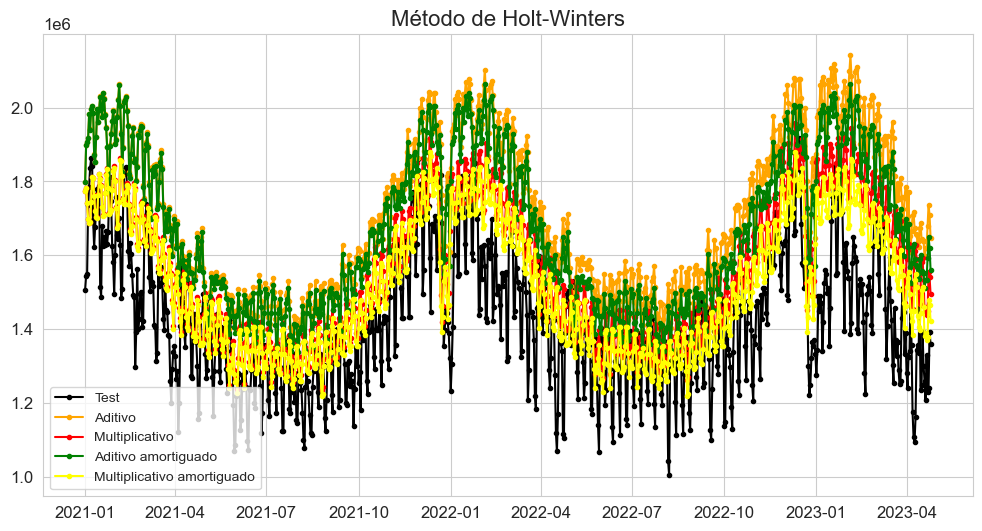

In [33]:
plt.figure(figsize=(12, 6))
plt.title("Método de Holt-Winters")

# (data1,) = plt.plot(train4, marker=".", color="black")
(data2,) = plt.plot(test4, marker=".",  color="black", label='Test')

(line1,) = plt.plot(HW_fcast1, marker=".", color="orange", label='Aditivo')
(line2,) = plt.plot(HW_fcast2, marker=".", color="red", label='Multiplicativo')
(line3,) = plt.plot(HW_fcast3, marker=".", color="green", label='Aditivo amortiguado')
(line4,) = plt.plot(HW_fcast4,marker=".", color="yellow", label='Multiplicativo amortiguado')
# plt.axvline(datetime.date(2021,1,1), color="blue", ls="--")
plt.legend(loc='lower left', fontsize=10)
plt.savefig("../graphs/HoltWinters2.jpg")

In [35]:
results3 = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE", "MAPE", 'MSE', "Time"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
results3["Additive"]       = [HW1.params[p] for p in params] + [HW1.sse] + [mean_absolute_percentage_error(y_pred=HW_fcast1, y_true=test4)] + [mean_squared_error(y_pred=HW_fcast1, y_true=test4)] + [datetime.timedelta(seconds=t2-t1)]
results3["Multiplicative"] = [HW2.params[p] for p in params] + [HW2.sse] + [mean_absolute_percentage_error(y_pred=HW_fcast2, y_true=test4)] + [mean_squared_error(y_pred=HW_fcast2, y_true=test4)] + [datetime.timedelta(seconds=t3-t2)]
results3["Additive Dam"]   = [HW3.params[p] for p in params] + [HW3.sse] + [mean_absolute_percentage_error(y_pred=HW_fcast3, y_true=test4)] + [mean_squared_error(y_pred=HW_fcast3, y_true=test4)] + [datetime.timedelta(seconds=t4-t3)]
results3["Multiplica Dam"] = [HW4.params[p] for p in params] + [HW4.sse] + [mean_absolute_percentage_error(y_pred=HW_fcast4, y_true=test4)] + [mean_squared_error(y_pred=HW_fcast4, y_true=test4)] + [datetime.timedelta(seconds=t5-t4)]




results3


,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,0.606071,0.995,0.606071,0.995
$\beta$,0.0001,0.0001,0.0001,0.0001
$\phi$,NaN,NaN,0.99,0.99
$\gamma$,0.393929,0.005,0.393929,0.005
$l_0$,1798649.364048,1798649.364048,1798649.364048,1798649.364048
$b_0$,177.841644,177.841644,177.841644,177.841644
SSE,68836066979313.8125,68128196338533.273438,68835522214011.03125,68126820044666.96875
MAPE,24.130425,17.089567,21.925652,15.750295
MSE,101331982049.586441,41059889182.678703,77727479920.883789,30742572010.276588
Time,0:00:00.976452,0:00:01.551879,0:00:00.962641,0:00:01.379397


In [36]:
results3.to_csv('../data/results/HoltWinters.csv')

#### Second model
In this model, we reduce the number observations. We use
 * 01-05-2020 to 31-12-2020 for the train set
 * 01-01-2021 to 01-05-2021 for the test set. 
 
 We will work with monthly seasonality.

In [34]:
train = pd.read_parquet("../data/03_train-test/train_data.parquet")
test = pd.read_parquet("../data/03_train-test/test_data.parquet")

In [35]:
train = train.set_index('ds')
train5 = train.loc[train.index > '2020-05-01']
test = test.set_index('ds')
test5 = test.loc[test.index < '2021-05-01']

In [36]:
%%time
fit = ExponentialSmoothing(train5['y'],
                           trend='add',
                           seasonal='add',
                           seasonal_periods=48*30,
                           initialization_method="estimated",
                          ).fit(smoothing_level=0.2, smoothing_trend=0.0001, smoothing_seasonal=0.1)

Wall time: 3min 43s


In [37]:
%%time
fcast = fit.forecast(len(test5))

Wall time: 190 ms


In [109]:
print('MAPE: ', mean_absolute_percentage_error(y_pred=fcast, y_true=test5))
print('MSE: ', mean_squared_error(y_pred=fcast, y_true=test5))

MAPE:  23.634592074759038
MSE:  40035955.32074


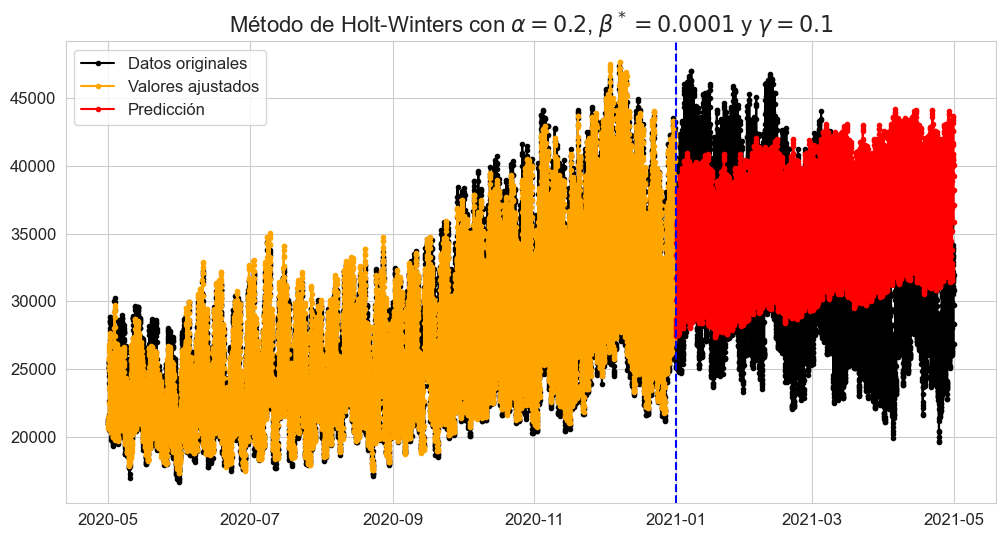

In [39]:
plt.figure(figsize=(12, 6))
plt.title(r'Método de Holt-Winters con $\alpha=0.2$, $\beta^*=0.0001$ y $\gamma=0.1$')

plt.plot(train5.index, train5['y'], marker=".", color="black", label='Datos originales')
plt.plot(test5.index, test5['y'], marker=".", color='k')
plt.plot(train5.index, fit.fittedvalues, marker=".", color="orange", label='Valores ajustados')
plt.plot(test5.index, fcast, color="red", marker=".", label='Predicción')
plt.axvline(datetime.date(2021,1,1), color="blue", ls="--")
plt.legend()
plt.savefig("../graphs/HoltWinters4.jpg")

In [105]:
# this is working with weekly seasonality
t1 = time.perf_counter()
HW_c1 = ExponentialSmoothing(
    train5['y'],
    seasonal_periods=48*7,
    trend="add",
    seasonal="add",
#     freq='D',
    initialization_method="estimated").fit()
HW_c_fcast1 = HW_c1.forecast(len(test5))

t2 = time.perf_counter()
HW_c2 = ExponentialSmoothing(
    train5['y'],
    seasonal_periods=48*7,
    trend="add",
    seasonal="mul",
#     freq='D',
    initialization_method="estimated").fit()
HW_c_fcast2 = HW_c2.forecast(len(test5))

t3 = time.perf_counter()
HW_c3 = ExponentialSmoothing(
    train5['y'],
    seasonal_periods=48*7,
    trend="add",
    seasonal="add",
#     freq='D',
    damped_trend=True,
    initialization_method="estimated").fit()
HW_c_fcast3 = HW_c3.forecast(len(test5))

t4 = time.perf_counter()
HW_c4 = ExponentialSmoothing(
    train5['y'],
    seasonal_periods=48*7,
    trend="add",
    seasonal="mul",
#     freq='D',
    damped_trend=True,
    initialization_method="estimated").fit()
HW_c_fcast4 = HW_c4.forecast(len(test5))
t5 = time.perf_counter()

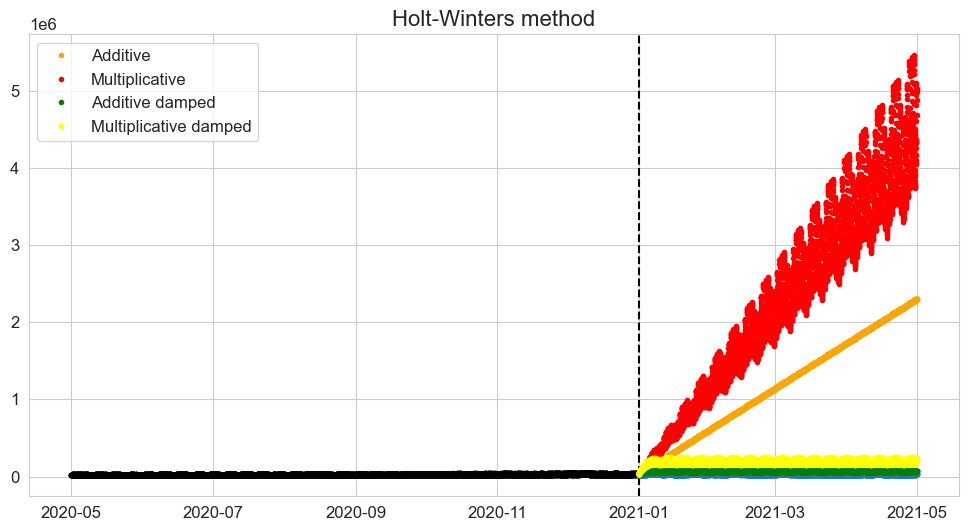

In [107]:
plt.figure(figsize=(12, 6))
plt.title("Holt-Winters method")
plt.axvline(datetime.date(2021,1,1), color="black", ls="--")
plt.plot(train5.index, train5['y'], marker=".", color="black")
plt.plot(test5.index, test5['y'], marker=".")
# plt.ylim(-0.75e6, 0.5e6)

(line1,) = plt.plot(test5.index, HW_c_fcast1, ".", color="orange", label='Additive')
(line2,) = plt.plot(test5.index, HW_c_fcast2, ".", color="red", label='Multiplicative')
(line3,) = plt.plot(test5.index, HW_c_fcast3, ".", color="green", label='Additive damped')
(line4,) = plt.plot(test5.index, HW_c_fcast4, ".", color="yellow", label='Multiplicative damped')
plt.legend()
plt.savefig("../graphs/HoltWinters5.jpg")

In [108]:
results4 = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE", "MAPE", "Time"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
results4["Additive"] = [HW_c1.params[p] for p in params] + [HW_c1.sse] + [mean_absolute_percentage_error(y_pred=HW_c_fcast1, y_true=test5['y'])] + [datetime.timedelta(seconds=t2-t1)]
results4["Multiplicative"] = [HW_c2.params[p] for p in params] + [HW_c2.sse] + [mean_absolute_percentage_error(y_pred=HW_c_fcast2, y_true=test5['y'])] + [datetime.timedelta(seconds=t3-t2)]
results4["Additive Dam"] = [HW_c3.params[p] for p in params] + [HW_c3.sse] + [mean_absolute_percentage_error(y_pred=HW_c_fcast3, y_true=test5['y'])] + [datetime.timedelta(seconds=t4-t3)]
results4["Multiplica Dam"] = [HW_c4.params[p] for p in params] + [HW_c4.sse] + [mean_absolute_percentage_error(y_pred=HW_c_fcast4, y_true=test5['y'])] + [datetime.timedelta(seconds=t5-t4)]




results4

,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,0.995,0.995,0.995,0.995
$\beta$,0.817321,0.817321,0.817321,0.817321
$\phi$,NaN,NaN,0.99,0.99
$\gamma$,0.005,0.005,0.005,0.005
$l_0$,23612.571429,23612.571429,23612.571429,23612.571428
$b_0$,-4.11599,-4.11599,-4.11599,-4.11599
SSE,2208869494.279627,2442478550.021785,2187112180.198802,55679144994.059288
MAPE,3836.885611,7239.349221,118.852913,513.067608
Time,0:00:05.830526,0:00:07.061167,0:00:05.880718,0:00:07.596390
